# Modélisation de la Transition Énergétique en France

Ce notebook reproduit les calculs du fichier ODS "modélisation générale.ods".

**Objectif principal:** Calculer le besoin brut en énergie d'appoint (gaz) pour assurer la saison hivernale.

**Résultat clé:** ~114 TWh (100 milliards de kWh)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Données Exactes du Tableur Original

On reproduit directement les valeurs de la feuille "moulinette simplifiée avec PAC".

In [2]:
# =============================================================================
# LECTURE DIRECTE DU FICHIER ODS
# Feuille: "moulinette simplifiée avec PAC"
# =============================================================================

import zipfile
import xml.etree.ElementTree as ET
from pathlib import Path

# Chemin vers le fichier ODS
ODS_PATH = Path("..") / "modélisation générale.ods"

# Namespaces ODF
ns = {
    'office': 'urn:oasis:names:tc:opendocument:xmlns:office:1.0',
    'table': 'urn:oasis:names:tc:opendocument:xmlns:table:1.0',
    'text': 'urn:oasis:names:tc:opendocument:xmlns:text:1.0',
}

def get_cell_value(cell):
    """Extrait la valeur numérique ou texte d'une cellule ODS"""
    value = cell.get('{urn:oasis:names:tc:opendocument:xmlns:office:1.0}value')
    if value:
        return float(value)
    text_elem = cell.find('.//text:p', ns)
    if text_elem is not None and text_elem.text:
        return text_elem.text
    return None

def expand_row(row, max_cols=25):
    """Expanse les cellules répétées dans une ligne ODS"""
    cells = []
    for cell in row.findall('table:table-cell', ns):
        repeat = cell.get('{urn:oasis:names:tc:opendocument:xmlns:table:1.0}number-columns-repeated')
        repeat = int(repeat) if repeat else 1
        repeat = min(repeat, max_cols - len(cells))
        value = get_cell_value(cell)
        for _ in range(repeat):
            cells.append(value)
            if len(cells) >= max_cols:
                break
        if len(cells) >= max_cols:
            break
    return cells

# Lire le fichier ODS
with zipfile.ZipFile(ODS_PATH, 'r') as z:
    content = z.read('content.xml')

root = ET.fromstring(content)
body = root.find('.//office:spreadsheet', ns)
tables = body.findall('table:table', ns)

# Trouver la feuille "moulinette simplifiée avec PAC"
target_sheet = None
for table in tables:
    name = table.get('{urn:oasis:names:tc:opendocument:xmlns:table:1.0}name')
    if 'moulinette simplifiée avec PAC' in name:
        target_sheet = table
        print(f"✓ Feuille trouvée: '{name}'")
        break

if not target_sheet:
    raise ValueError("Feuille 'moulinette simplifiée avec PAC' non trouvée!")

# Extraire les données
rows = list(target_sheet.findall('table:table-row', ns))
print(f"✓ {len(rows)} lignes dans la feuille")

# Colonnes clés:
# A (0): Période (mois + plage horaire)
# H (7): Total production (kW)
# P (15): Total consommation (kW)
# Q (16): Déficit/besoin gaz (kW)
# R (17): Durée plage horaire (h)
# S (18): Énergie gaz (TWh)

data = []
for row_idx in range(3, 65):  # Lignes de données (après en-têtes)
    cells = expand_row(rows[row_idx])
    if len(cells) > 18 and cells[0]:
        period = str(cells[0])
        h_val = cells[7]   # Production
        p_val = cells[15]  # Consommation
        q_val = cells[16]  # Déficit
        r_val = cells[17]  # Durée
        s_val = cells[18]  # Énergie TWh
        
        if isinstance(h_val, (int, float)) and isinstance(p_val, (int, float)):
            data.append({
                'Periode': period,
                'Production_kW': h_val,
                'Consommation_kW': p_val,
                'Deficit_kW': q_val if isinstance(q_val, (int, float)) else 0,
                'Duree_h': r_val if isinstance(r_val, (int, float)) else 0,
                'Energie_TWh_ODS': s_val if isinstance(s_val, (int, float)) else 0,
            })

df = pd.DataFrame(data)
print(f"✓ {len(df)} lignes de données extraites")

# Afficher les premières lignes
df.head(10)

✓ Feuille trouvée: 'moulinette simplifiée avec PAC'
✓ 87 lignes dans la feuille
✓ 60 lignes de données extraites


/tmp/ipykernel_1383071/2303849392.py:63: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  if not target_sheet:


,Periode,Production_kW,Consommation_kW,Deficit_kW,Duree_h,Energie_TWh_ODS
0,Janvier 8 heures 13 heures,1.591756e+08,2.444968e+08,8.532112e+07,5.0,12.798167
1,Janvier 13 heures 18 heures,1.591756e+08,2.444968e+08,8.532112e+07,5.0,12.798167
2,Janvier 18 heures 20 heures,5.860375e+07,9.219737e+07,3.359362e+07,2.0,2.015617
3,Janvier 20 heures 23 heures,5.860375e+07,7.889682e+07,2.029307e+07,3.0,1.826377
4,Janvier 23 heures 8 heures,5.860375e+07,4.646711e+07,-1.213664e+07,9.0,0.000000
5,fevrier 8 heures 13 heures,1.808943e+08,2.305275e+08,4.963325e+07,5.0,7.444988
6,fevrier 13 heures 18 heures,1.808943e+08,2.305275e+08,4.963325e+07,5.0,7.444988
7,fevrier 18 heures 20 heures,5.664212e+07,7.822812e+07,2.158600e+07,2.0,1.295160
8,fevrier 20 heures 23 heures,5.664212e+07,6.492757e+07,8.285454e+06,3.0,0.745691
9,fevrier 23 heures 8 heures,5.664212e+07,3.715428e+07,-1.948784e+07,9.0,0.000000


## 2. Vérification de la Formule de Calcul

La formule du tableur est:

$$S_{TWh} = \frac{Q_{kW} \times R_{heures} \times 30_{jours}}{10^9}$$

In [3]:
# =============================================================================
# VÉRIFICATION DE LA FORMULE
# S (TWh) = Q (kW) × R (heures/jour) × 30 (jours/mois) / 1e9
# =============================================================================

JOURS_PAR_MOIS = 30

def calculer_energie_twh(deficit_kw, duree_h):
    """Calcule l'énergie en TWh selon la formule du tableur"""
    if deficit_kw <= 0:
        return 0
    return deficit_kw * duree_h * JOURS_PAR_MOIS / 1e9

# Appliquer le calcul
df['Energie_TWh_calcul'] = df.apply(
    lambda row: calculer_energie_twh(row['Deficit_kW'], row['Duree_h']), 
    axis=1
)

# Vérifier que nos calculs correspondent au tableur (seulement pour valeurs > 0)
df_check = df[df['Energie_TWh_ODS'] > 0].copy()
df_check['Ecart'] = abs(df_check['Energie_TWh_ODS'] - df_check['Energie_TWh_calcul'])

print("Vérification des calculs (les écarts doivent être < 0.1 TWh):")
print(f"Lignes avec énergie positive: {len(df_check)}")
print(f"Écart maximum: {df_check['Ecart'].max():.4f} TWh")
print(f"Écart moyen: {df_check['Ecart'].mean():.4f} TWh")

# Afficher quelques exemples
print("\nExemples de calculs (lignes avec déficit):")
for idx, row in df_check.head(5).iterrows():
    print(f"{row['Periode'][:35]}: Q={row['Deficit_kW']/1e6:.1f} MW × {row['Duree_h']:.0f}h × 30j / 1e9 = {row['Energie_TWh_calcul']:.2f} TWh (ODS: {row['Energie_TWh_ODS']:.2f})")

Vérification des calculs (les écarts doivent être < 0.1 TWh):
Lignes avec énergie positive: 24
Écart maximum: 0.0000 TWh
Écart moyen: 0.0000 TWh

Exemples de calculs (lignes avec déficit):
Janvier 8 heures 13 heures: Q=85.3 MW × 5h × 30j / 1e9 = 12.80 TWh (ODS: 12.80)
Janvier 13 heures 18 heures: Q=85.3 MW × 5h × 30j / 1e9 = 12.80 TWh (ODS: 12.80)
Janvier 18 heures 20 heures: Q=33.6 MW × 2h × 30j / 1e9 = 2.02 TWh (ODS: 2.02)
Janvier 20 heures 23 heures: Q=20.3 MW × 3h × 30j / 1e9 = 1.83 TWh (ODS: 1.83)
fevrier 8 heures 13 heures: Q=49.6 MW × 5h × 30j / 1e9 = 7.44 TWh (ODS: 7.44)


## 3. Calcul du Total: Les 114 TWh

In [4]:
# =============================================================================
# CALCUL DU TOTAL ANNUEL
# =============================================================================

# Extraire le mois de la période
def extraire_mois(periode):
    periode_lower = periode.lower()
    mois_map = {
        'janvier': 'Janvier', 'fevrier': 'Février', 'février': 'Février',
        'mars': 'Mars', 'avril': 'Avril', 'mai': 'Mai', 'juin': 'Juin',
        'juillet': 'Juillet', 'aout': 'Août', 'août': 'Août',
        'septembre': 'Septembre', 'octobre': 'Octobre',
        'novembre': 'Novembre', 'decembre': 'Décembre', 'décembre': 'Décembre'
    }
    for key, val in mois_map.items():
        if key in periode_lower:
            return val
    return 'Inconnu'

df['Mois'] = df['Periode'].apply(extraire_mois)

# Résumé par mois - utiliser les valeurs du tableur (Energie_TWh_ODS)
resume_mois = df.groupby('Mois').agg({
    'Energie_TWh_ODS': 'sum',
    'Production_kW': 'mean',
    'Consommation_kW': 'mean',
    'Deficit_kW': 'mean'
}).round(2)

# Réordonner les mois
ordre_mois = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin',
              'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
resume_mois = resume_mois.reindex(ordre_mois)

print("=" * 70)
print("BESOIN EN ÉNERGIE D'APPOINT GAZ PAR MOIS (données ODS)")
print("=" * 70)
print(f"{'Mois':<12} {'Énergie (TWh)':<15} {'Prod moy (GW)':<15} {'Conso moy (GW)':<15}")
print("-" * 70)

for mois in ordre_mois:
    if mois in resume_mois.index:
        row = resume_mois.loc[mois]
        bar = "█" * int(row['Energie_TWh_ODS'] * 1.5)
        print(f"{mois:<12} {row['Energie_TWh_ODS']:>8.2f} TWh   {row['Production_kW']/1e6:>8.1f} GW     {row['Consommation_kW']/1e6:>8.1f} GW   {bar}")

total = df['Energie_TWh_ODS'].sum()
print("=" * 70)
print(f"{'TOTAL ANNUEL':<12} {total:>8.2f} TWh")
print("=" * 70)
print(f"\n→ Soit environ {total:.0f} TWh = {total*10:.0f} milliards de kWh")

BESOIN EN ÉNERGIE D'APPOINT GAZ PAR MOIS (données ODS)
Mois         Énergie (TWh)   Prod moy (GW)   Conso moy (GW) 
----------------------------------------------------------------------
Janvier         29.44 TWh       98.8 GW        141.3 GW   ████████████████████████████████████████████
Février         16.93 TWh      106.3 GW        128.3 GW   █████████████████████████
Mars             2.35 TWh      149.9 GW        120.4 GW   ███
Avril            1.57 TWh      143.2 GW        112.2 GW   ██
Mai              0.00 TWh      130.2 GW         77.1 GW   
Juin             0.00 TWh      150.2 GW         77.1 GW   
Juillet          0.00 TWh      153.9 GW         77.1 GW   
Août             0.00 TWh      125.9 GW         77.1 GW   
Septembre        0.00 TWh      123.9 GW         77.1 GW   
Octobre          9.79 TWh      120.3 GW        102.9 GW   ██████████████
Novembre        26.14 TWh       91.1 GW        127.8 GW   ███████████████████████████████████████
Décembre        28.60 TWh       92.5 

In [5]:
# =============================================================================
# DÉTECTION DES ANOMALIES DANS LES DONNÉES DU TABLEUR
# =============================================================================

print("=" * 80)
print("ANALYSE DES ANOMALIES - Vérification de la cohérence physique")
print("=" * 80)

# Heures de coucher du soleil en France (Paris) par mois
# Source: worlddata.info/europe/france/sunset.php
SUNSET_TIMES = {
    'Janvier': 17.4,    # 17:23
    'Février': 18.2,    # 18:12
    'Mars': 18.9,       # 18:56
    'Avril': 20.7,      # 20:43
    'Mai': 21.5,        # 21:27
    'Juin': 22.0,       # 21:57
    'Juillet': 21.9,    # 21:51
    'Août': 21.1,       # 21:08
    'Septembre': 20.1,  # 20:05
    'Octobre': 19.1,    # 19:03
    'Novembre': 17.2,   # 17:12
    'Décembre': 16.9,   # 16:56
}

# Extraire la plage horaire
def extraire_plage(periode):
    periode_lower = periode.lower()
    # NB: '18 heures' contient '8 heure', donc on vérifie l'absence de '18' pour 8h-13h
    if '8 heure' in periode_lower and '13' in periode_lower and '18' not in periode_lower:
        return '8h-13h'
    elif '13 heure' in periode_lower and '18' in periode_lower:
        return '13h-18h'
    elif '18 heure' in periode_lower and '20' in periode_lower:
        return '18h-20h'
    elif '20 heure' in periode_lower and '23' in periode_lower:
        return '20h-23h'
    elif '23 heure' in periode_lower:
        return '23h-8h'
    return 'Autre'

df['Plage'] = df['Periode'].apply(extraire_plage)

# Production de base (nucléaire + hydraulique) - pas de solaire
# En France: nucléaire ~30-50 GW + hydraulique ~5-10 GW = ~40-60 GW max sans solaire
PROD_BASE_MAX = 65  # GW - production max possible sans solaire

def est_plage_nocturne(mois, plage):
    """Détermine si une plage horaire est nocturne (pas de soleil) pour un mois donné"""
    sunset = SUNSET_TIMES.get(mois, 18)
    
    if plage == '23h-8h':
        return True  # Toujours nocturne
    elif plage == '20h-23h':
        # Nocturne si le soleil se couche avant 20h
        return sunset < 20
    elif plage == '18h-20h':
        # Nocturne si le soleil se couche avant 18h
        return sunset < 18
    return False

def fraction_solaire_attendue(mois, plage):
    """Estime la fraction de la plage avec ensoleillement (0 à 1)"""
    sunset = SUNSET_TIMES.get(mois, 18)
    
    if plage == '8h-13h' or plage == '13h-18h':
        return 1.0  # Plein jour
    elif plage == '18h-20h':
        if sunset >= 20:
            return 1.0  # Soleil présent toute la plage
        elif sunset <= 18:
            return 0.0  # Nuit
        else:
            return (sunset - 18) / 2  # Fraction partielle
    elif plage == '20h-23h':
        if sunset >= 23:
            return 1.0  # Rare mais possible en été
        elif sunset <= 20:
            return 0.0  # Nuit
        else:
            return (sunset - 20) / 3  # Fraction partielle
    elif plage == '23h-8h':
        return 0.0  # Toujours nuit
    return 0.5

print("\n📊 HEURES DE COUCHER DU SOLEIL EN FRANCE (Paris):")
print("-" * 50)
for mois in ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 
             'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']:
    h = int(SUNSET_TIMES[mois])
    m = int((SUNSET_TIMES[mois] - h) * 60)
    print(f"  {mois:<10}: {h:02d}:{m:02d}")

print("\n⚠️  ANOMALIES DÉTECTÉES:")
print("-" * 80)

anomalies = []
for _, row in df.iterrows():
    prod_gw = row['Production_kW'] / 1e6
    plage = row['Plage']
    mois = row['Mois']
    
    # Calculer la production max attendue selon l'ensoleillement
    fraction_soleil = fraction_solaire_attendue(mois, plage)
    
    # Production solaire max théorique ~150 GW en été (sur 500 GWc installés)
    prod_solaire_max = 150  # GW
    prod_max_attendue = PROD_BASE_MAX + fraction_soleil * prod_solaire_max
    
    # Vérifier si la production est anormalement élevée
    if prod_gw > prod_max_attendue + 20:  # Marge de 20 GW
        anomalies.append({
            'Mois': mois,
            'Plage': plage,
            'Production_GW': prod_gw,
            'Attendu_max_GW': prod_max_attendue,
            'Ecart_GW': prod_gw - prod_max_attendue,
            'Fraction_soleil': fraction_soleil,
            'Periode': row['Periode']
        })
        sunset = SUNSET_TIMES.get(mois, 18)
        print(f"  ❌ {mois} {plage}: Production = {prod_gw:.1f} GW")
        print(f"     → Coucher du soleil: {int(sunset)}:{int((sunset%1)*60):02d}")
        print(f"     → Fraction solaire attendue: {fraction_soleil*100:.0f}%")
        print(f"     → Production max attendue: ~{prod_max_attendue:.0f} GW")
        print(f"     → Excès de {prod_gw - prod_max_attendue:.1f} GW")
        print()

if not anomalies:
    print("  ✓ Aucune anomalie détectée - les productions sont cohérentes avec l'ensoleillement")
else:
    print("-" * 80)
    print(f"\n📊 RÉSUMÉ: {len(anomalies)} anomalie(s) détectée(s)")

ANALYSE DES ANOMALIES - Vérification de la cohérence physique

📊 HEURES DE COUCHER DU SOLEIL EN FRANCE (Paris):
--------------------------------------------------
  Janvier   : 17:23
  Février   : 18:11
  Mars      : 18:53
  Avril     : 20:41
  Mai       : 21:30
  Juin      : 22:00
  Juillet   : 21:53
  Août      : 21:06
  Septembre : 20:06
  Octobre   : 19:06
  Novembre  : 17:11
  Décembre  : 16:53

⚠️  ANOMALIES DÉTECTÉES:
--------------------------------------------------------------------------------
  ❌ Mars 18h-20h: Production = 215.9 GW
     → Coucher du soleil: 18:53
     → Fraction solaire attendue: 45%
     → Production max attendue: ~132 GW
     → Excès de 83.4 GW

  ❌ Juillet 20h-23h: Production = 183.3 GW
     → Coucher du soleil: 21:53
     → Fraction solaire attendue: 63%
     → Production max attendue: ~160 GW
     → Excès de 23.3 GW

  ❌ Octobre 18h-20h: Production = 170.7 GW
     → Coucher du soleil: 19:06
     → Fraction solaire attendue: 55%
     → Production max at

In [6]:
# =============================================================================
# DÉTAIL DES MOIS D'HIVER
# =============================================================================

mois_hiver = ['Octobre', 'Novembre', 'Décembre', 'Janvier', 'Février', 'Mars', 'Avril']
df_hiver = df[df['Mois'].isin(mois_hiver)].copy()

print("\n" + "=" * 100)
print("DÉTAIL PAR PLAGE HORAIRE - MOIS D'HIVER (données directes du tableur ODS)")
print("=" * 100)

for mois in mois_hiver:
    df_mois = df_hiver[df_hiver['Mois'] == mois]
    total_mois = df_mois['Energie_TWh_ODS'].sum()
    sunset = SUNSET_TIMES.get(mois, 18)
    print(f"\n{mois.upper()} (Total: {total_mois:.2f} TWh) - Coucher du soleil: {int(sunset)}:{int((sunset%1)*60):02d}")
    
    for _, row in df_mois.iterrows():
        prod_gw = row['Production_kW'] / 1e6
        conso_gw = row['Consommation_kW'] / 1e6
        deficit_gw = row['Deficit_kW'] / 1e6 if row['Deficit_kW'] > 0 else 0
        energie = row['Energie_TWh_ODS']
        duree = row['Duree_h']
        plage = row['Plage']
        
        # Calculer si c'est une anomalie basée sur l'ensoleillement réel
        fraction_soleil = fraction_solaire_attendue(mois, plage)
        prod_max_attendue = PROD_BASE_MAX + fraction_soleil * 150  # 150 GW solaire max
        is_anomaly = prod_gw > prod_max_attendue + 20
        anomaly_marker = f" ⚠️ ANOMALIE (max attendu: {prod_max_attendue:.0f} GW)" if is_anomaly else ""
        
        if energie > 0:
            print(f"  {plage:<8} | Prod: {prod_gw:6.1f} GW | Conso: {conso_gw:6.1f} GW | Déficit: {deficit_gw:5.1f} GW | {duree:.0f}h → {energie:5.2f} TWh{anomaly_marker}")
        elif row['Deficit_kW'] < 0:
            status = "SURPLUS" + anomaly_marker
            print(f"  {plage:<8} | Prod: {prod_gw:6.1f} GW | Conso: {conso_gw:6.1f} GW | {status}")


DÉTAIL PAR PLAGE HORAIRE - MOIS D'HIVER (données directes du tableur ODS)

OCTOBRE (Total: 9.79 TWh) - Coucher du soleil: 19:06
  8h-13h   | Prod:  170.7 GW | Conso:  203.3 GW | Déficit:  32.6 GW | 5h →  4.89 TWh
  13h-18h  | Prod:  170.7 GW | Conso:  203.3 GW | Déficit:  32.6 GW | 5h →  4.89 TWh
  18h-20h  | Prod:  170.7 GW | Conso:   51.0 GW | SURPLUS ⚠️ ANOMALIE (max attendu: 148 GW)
  20h-23h  | Prod:   44.8 GW | Conso:   37.7 GW | SURPLUS
  23h-8h   | Prod:   44.8 GW | Conso:   19.0 GW | SURPLUS

NOVEMBRE (Total: 26.14 TWh) - Coucher du soleil: 17:11
  8h-13h   | Prod:  152.7 GW | Conso:  230.0 GW | Déficit:  77.3 GW | 5h → 11.59 TWh
  13h-18h  | Prod:  152.7 GW | Conso:  230.0 GW | Déficit:  77.3 GW | 5h → 11.59 TWh
  18h-20h  | Prod:   50.1 GW | Conso:   77.7 GW | Déficit:  27.7 GW | 2h →  1.66 TWh
  20h-23h  | Prod:   50.1 GW | Conso:   64.4 GW | Déficit:  14.4 GW | 3h →  1.29 TWh
  23h-8h   | Prod:   50.1 GW | Conso:   36.8 GW | SURPLUS

DÉCEMBRE (Total: 28.60 TWh) - Coucher 

## 4. Analyse des Hypothèses du Modèle

In [7]:
# =============================================================================
# PARAMÈTRES DU MODÈLE (extraits du tableur)
# =============================================================================

print("HYPOTHÈSES DE PRODUCTION")
print("=" * 50)

# Photovoltaïque
print("\n📌 Photovoltaïque:")
print("  - Maisons individuelles: 20 millions × 10 kWc = 200 GWc")
print("  - Logements collectifs: 10 millions × 5 kWc = 50 GWc")
print("  - Centrales solaires: 250 GWc")
print("  → TOTAL PV: 500 GWc installés")

# Nucléaire
print("\n📌 Nucléaire:")
print("  - Maintenu au niveau actuel (données RTE 2020)")
print("  - Variation saisonnière: ~30 GW (été) à ~50 GW (hiver)")

# Hydraulique  
print("\n📌 Hydraulique:")
print("  - Maintenu au niveau actuel (données RTE 2020)")
print("  - Moyenne: ~7-10 GW selon les mois")

# Éolien
print("\n📌 Éolien:")
print("  - Non comptabilisé (considéré trop irrégulier)")
print("  - C'est une hypothèse conservatrice")

print("\n" + "=" * 50)
print("HYPOTHÈSES DE CONSOMMATION")
print("=" * 50)

print("\n📌 Chauffage résidentiel:")
print("  - Électrification avec pompes à chaleur (PAC)")
print("  - COP moyen = 2 (division par 2 de la conso thermique)")
print("  - Réparti sur 67% de la conso résidentielle")

print("\n📌 Transports:")
print("  - Électrification progressive")
print("  - Correction rendement moteur (×0.4 pour marchandises)")

print("\n📌 Industrie/Tertiaire:")
print("  - Maintenu au niveau actuel")

HYPOTHÈSES DE PRODUCTION

📌 Photovoltaïque:
  - Maisons individuelles: 20 millions × 10 kWc = 200 GWc
  - Logements collectifs: 10 millions × 5 kWc = 50 GWc
  - Centrales solaires: 250 GWc
  → TOTAL PV: 500 GWc installés

📌 Nucléaire:
  - Maintenu au niveau actuel (données RTE 2020)
  - Variation saisonnière: ~30 GW (été) à ~50 GW (hiver)

📌 Hydraulique:
  - Maintenu au niveau actuel (données RTE 2020)
  - Moyenne: ~7-10 GW selon les mois

📌 Éolien:
  - Non comptabilisé (considéré trop irrégulier)
  - C'est une hypothèse conservatrice

HYPOTHÈSES DE CONSOMMATION

📌 Chauffage résidentiel:
  - Électrification avec pompes à chaleur (PAC)
  - COP moyen = 2 (division par 2 de la conso thermique)
  - Réparti sur 67% de la conso résidentielle

📌 Transports:
  - Électrification progressive
  - Correction rendement moteur (×0.4 pour marchandises)

📌 Industrie/Tertiaire:
  - Maintenu au niveau actuel


## 5. Visualisations

In [8]:
# =============================================================================
# TABLEAU: BESOIN GAZ PAR PLAGE HORAIRE (mois d'hiver)
# =============================================================================

print("=" * 90)
print("BESOIN GAZ PAR PLAGE HORAIRE - MOIS D'HIVER (Oct-Avril)")
print("=" * 90)

plages_ordre = ['8h-13h', '13h-18h', '18h-20h', '20h-23h', '23h-8h']

# Créer un tableau croisé mois x plage
print(f"\n{'Mois':<12}", end="")
for plage in plages_ordre:
    print(f"{plage:>12}", end="")
print(f"{'TOTAL':>12}")
print("-" * 90)

mois_ordre_hiver = ['Octobre', 'Novembre', 'Décembre', 'Janvier', 'Février', 'Mars', 'Avril']
totaux_plages = {p: 0 for p in plages_ordre}

for mois in mois_ordre_hiver:
    df_mois = df_hiver[df_hiver['Mois'] == mois]
    print(f"{mois:<12}", end="")
    total_mois = 0
    for plage in plages_ordre:
        df_p = df_mois[df_mois['Plage'] == plage]
        if len(df_p) > 0:
            val = df_p['Energie_TWh_ODS'].values[0]
            deficit = df_p['Deficit_kW'].values[0] / 1e6
            if val > 0:
                print(f"{val:>10.2f}  ", end="")
            elif deficit < 0:
                print(f"{'SURPLUS':>10}  ", end="")
            else:
                print(f"{0:>10.2f}  ", end="")
            total_mois += val
            totaux_plages[plage] += val
        else:
            print(f"{'-':>10}  ", end="")
    print(f"{total_mois:>10.2f}")

print("-" * 90)
print(f"{'TOTAL':<12}", end="")
for plage in plages_ordre:
    print(f"{totaux_plages[plage]:>10.2f}  ", end="")
print(f"{sum(totaux_plages.values()):>10.2f}")

print("\n" + "=" * 90)
print("ANALYSE DE LA PLAGE NOCTURNE 23h-8h")
print("=" * 90)
print("\nLa plage 23h-8h montre systématiquement un SURPLUS (pas de besoin gaz):")
print(f"\n{'Mois':<12} {'Production':>12} {'Consommation':>14} {'Balance':>12} {'Explication'}")
print("-" * 90)

for mois in mois_ordre_hiver:
    df_night = df_hiver[(df_hiver['Mois'] == mois) & (df_hiver['Plage'] == '23h-8h')]
    if len(df_night) > 0:
        row = df_night.iloc[0]
        prod = row['Production_kW'] / 1e6
        conso = row['Consommation_kW'] / 1e6
        balance = prod - conso
        expl = "Nucléaire+hydro > conso nocturne"
        print(f"{mois:<12} {prod:>10.1f} GW {conso:>12.1f} GW {balance:>+10.1f} GW  {expl}")

print("\n→ La nuit, sans solaire, le nucléaire + hydraulique (~50-60 GW) suffit")

BESOIN GAZ PAR PLAGE HORAIRE - MOIS D'HIVER (Oct-Avril)

Mois              8h-13h     13h-18h     18h-20h     20h-23h      23h-8h       TOTAL
------------------------------------------------------------------------------------------
Octobre           4.89        4.89     SURPLUS     SURPLUS     SURPLUS        9.79
Novembre         11.59       11.59        1.66        1.29     SURPLUS       26.14
Décembre         12.72       12.72        1.74        1.42     SURPLUS       28.60
Janvier          12.80       12.80        2.02        1.83     SURPLUS       29.44
Février           7.44        7.44        1.30        0.75     SURPLUS       16.93
Mars              0.93        0.93     SURPLUS        0.49     SURPLUS        2.35
Avril             0.63        0.63     SURPLUS        0.31     SURPLUS        1.57
------------------------------------------------------------------------------------------
TOTAL            51.00       51.00        6.71        6.09        0.00      114.81

ANALYSE DE 

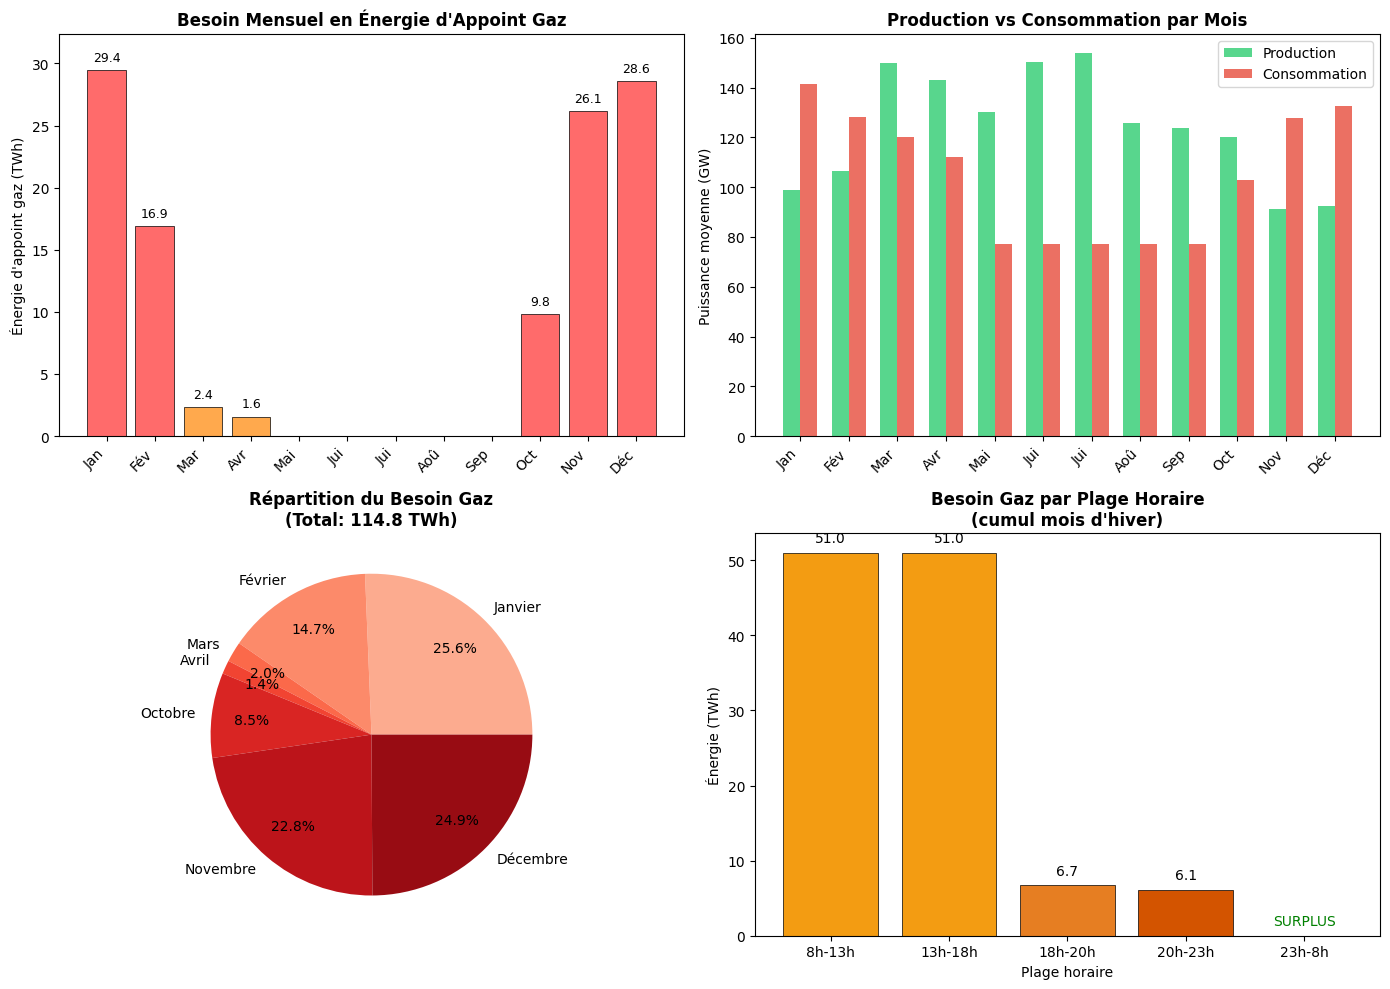


✓ Graphique sauvegardé: bilan_energetique_114twh.png


In [9]:
# =============================================================================
# GRAPHIQUES
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Besoin gaz par mois
ax1 = axes[0, 0]
energie_par_mois = resume_mois['Energie_TWh_ODS']
colors = ['#ff6b6b' if e > 5 else '#ffa94d' if e > 0 else '#69db7c' for e in energie_par_mois]
bars = ax1.bar(range(12), energie_par_mois, color=colors, edgecolor='black', linewidth=0.5)
ax1.set_xticks(range(12))
ax1.set_xticklabels([m[:3] for m in ordre_mois], rotation=45, ha='right')
ax1.set_ylabel('Énergie d\'appoint gaz (TWh)')
ax1.set_title('Besoin Mensuel en Énergie d\'Appoint Gaz', fontweight='bold')
ax1.axhline(y=0, color='black', linewidth=0.5)
ax1.set_ylim(0, max(energie_par_mois) * 1.1)

for i, v in enumerate(energie_par_mois):
    if v > 0:
        ax1.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# 2. Production vs Consommation
ax2 = axes[0, 1]
x = np.arange(12)
width = 0.35
prod = resume_mois['Production_kW'] / 1e6
conso = resume_mois['Consommation_kW'] / 1e6

rects1 = ax2.bar(x - width/2, prod, width, label='Production', color='#2ecc71', alpha=0.8)
rects2 = ax2.bar(x + width/2, conso, width, label='Consommation', color='#e74c3c', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels([m[:3] for m in ordre_mois], rotation=45, ha='right')
ax2.set_ylabel('Puissance moyenne (GW)')
ax2.set_title('Production vs Consommation par Mois', fontweight='bold')
ax2.legend(loc='upper right')

# 3. Répartition annuelle du besoin gaz
ax3 = axes[1, 0]
mois_deficit = energie_par_mois[energie_par_mois > 0]
if len(mois_deficit) > 0:
    colors_pie = plt.cm.Reds(np.linspace(0.3, 0.9, len(mois_deficit)))
    ax3.pie(mois_deficit, labels=mois_deficit.index, colors=colors_pie, autopct='%1.1f%%', pctdistance=0.75)
ax3.set_title(f'Répartition du Besoin Gaz\n(Total: {total:.1f} TWh)', fontweight='bold')

# 4. Besoin gaz par plage - avec surplus explicite
ax4 = axes[1, 1]
plages_ordre = ['8h-13h', '13h-18h', '18h-20h', '20h-23h', '23h-8h']
energie_plages = []
for plage in plages_ordre:
    val = df_hiver[df_hiver['Plage'] == plage]['Energie_TWh_ODS'].sum()
    energie_plages.append(val)

colors_plage = ['#f39c12', '#f39c12', '#e67e22', '#d35400', '#27ae60']  # Vert pour surplus
bars4 = ax4.bar(plages_ordre, energie_plages, color=colors_plage, edgecolor='black', linewidth=0.5)
ax4.set_ylabel('Énergie (TWh)')
ax4.set_xlabel('Plage horaire')
ax4.set_title('Besoin Gaz par Plage Horaire\n(cumul mois d\'hiver)', fontweight='bold')
ax4.axhline(y=0, color='black', linewidth=0.5)

for i, v in enumerate(energie_plages):
    label = f'{v:.1f}' if v > 0 else 'SURPLUS'
    ax4.text(i, max(v, 0) + 1, label, ha='center', va='bottom', fontsize=10, 
             color='green' if v == 0 else 'black')

plt.tight_layout()
plt.savefig('bilan_energetique_114twh.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Graphique sauvegardé: bilan_energetique_114twh.png")

In [10]:
# =============================================================================
# ANALYSE DE SENSIBILITÉ: SOLAIRE ADDITIONNEL vs BESOIN GAZ
# =============================================================================

print("=" * 90)
print("ANALYSE DE SENSIBILITÉ: Impact du solaire additionnel sur le besoin en gaz")
print("=" * 90)

# Étape 1: Extraire la production de base (nucléaire + hydro) depuis les plages nocturnes
# La nuit (23h-8h), il n'y a pas de solaire, donc prod = nucléaire + hydro
base_prod_by_month = {}
for mois in df['Mois'].unique():
    night_data = df[(df['Mois'] == mois) & (df['Plage'] == '23h-8h')]
    if len(night_data) > 0:
        base_prod_by_month[mois] = night_data['Production_kW'].values[0]

print("\n1. Production de base (nucléaire + hydro) par mois:")
for mois, prod in base_prod_by_month.items():
    print(f"   {mois}: {prod/1e6:.1f} GW")

# Étape 2: Calculer la contribution solaire actuelle et les facteurs de capacité
# Pour chaque plage de jour, solaire = production_totale - base
CAPACITE_SOLAIRE_ACTUELLE = 500  # GWc

solar_cf = {}  # Capacity factors par mois et plage
for _, row in df.iterrows():
    mois = row['Mois']
    plage = row['Plage']
    if plage in ['23h-8h']:  # Pas de solaire la nuit
        continue
    
    base = base_prod_by_month.get(mois, 50e6)
    total_prod = row['Production_kW']
    solar_prod = max(0, total_prod - base)
    
    # Facteur de capacité = production solaire / capacité installée
    cf = solar_prod / (CAPACITE_SOLAIRE_ACTUELLE * 1e6)  # en fraction
    
    key = (mois, plage)
    solar_cf[key] = {
        'cf': cf,
        'base_prod': base,
        'conso': row['Consommation_kW'],
        'duree': row['Duree_h']
    }

print(f"\n2. Facteurs de capacité solaire (exemples pour Janvier):")
for (mois, plage), data in solar_cf.items():
    if mois == 'Janvier':
        print(f"   {plage}: CF = {data['cf']*100:.1f}%")

# Étape 3: Fonctions de calcul du besoin gaz
def calculate_gas_need_no_storage(extra_solar_gwc):
    """Calcule le besoin gaz avec solaire additionnel, SANS stockage."""
    new_capacity = CAPACITE_SOLAIRE_ACTUELLE + extra_solar_gwc
    if new_capacity < 0:
        new_capacity = 0
    total_gas_twh = 0
    
    for (mois, plage), data in solar_cf.items():
        # Nouvelle production solaire
        new_solar = data['cf'] * new_capacity * 1e6  # kW
        new_total_prod = data['base_prod'] + new_solar
        
        # Nouveau déficit
        deficit = max(0, data['conso'] - new_total_prod)
        
        # Énergie gaz (TWh)
        gas_twh = deficit * data['duree'] * 30 / 1e9
        total_gas_twh += gas_twh
    
    # Ajouter les plages nocturnes (23h-8h) - inchangées car pas de solaire
    for mois in df['Mois'].unique():
        night_data = df[(df['Mois'] == mois) & (df['Plage'] == '23h-8h')]
        if len(night_data) > 0:
            row = night_data.iloc[0]
            deficit = max(0, row['Deficit_kW'])
            gas_twh = deficit * row['Duree_h'] * 30 / 1e9
            total_gas_twh += gas_twh
    
    return total_gas_twh

def calculate_gas_need_with_storage(extra_solar_gwc, efficiency=0.85):
    """Calcule le besoin gaz avec solaire additionnel ET stockage journalier."""
    new_capacity = CAPACITE_SOLAIRE_ACTUELLE + extra_solar_gwc
    if new_capacity < 0:
        new_capacity = 0
    total_gas_twh = 0
    
    for mois in df['Mois'].unique():
        # Calculer surplus et déficit journaliers pour ce mois
        daily_surplus_kwh = 0
        daily_deficit_kwh = 0
        
        for plage in ['8h-13h', '13h-18h', '18h-20h', '20h-23h', '23h-8h']:
            key = (mois, plage)
            
            if plage == '23h-8h':
                # Plage nocturne - pas de solaire mais peut avoir surplus
                night_data = df[(df['Mois'] == mois) & (df['Plage'] == plage)]
                if len(night_data) > 0:
                    row = night_data.iloc[0]
                    balance = row['Production_kW'] - row['Consommation_kW']
                    if balance > 0:
                        daily_surplus_kwh += balance * row['Duree_h']
                    else:
                        daily_deficit_kwh += abs(balance) * row['Duree_h']
            elif key in solar_cf:
                data = solar_cf[key]
                new_solar = data['cf'] * new_capacity * 1e6
                new_total_prod = data['base_prod'] + new_solar
                balance = new_total_prod - data['conso']
                
                if balance > 0:
                    daily_surplus_kwh += balance * data['duree']
                else:
                    daily_deficit_kwh += abs(balance) * data['duree']
        
        # Le stockage peut utiliser le surplus pour compenser le déficit
        usable_surplus = daily_surplus_kwh * efficiency
        net_deficit_kwh = max(0, daily_deficit_kwh - usable_surplus)
        
        # Convertir en TWh mensuel
        gas_twh = net_deficit_kwh * 30 / 1e9
        total_gas_twh += gas_twh
    
    return total_gas_twh

# Étape 4: Générer les données - ÉTENDU AUX VALEURS NÉGATIVES
# Range: -400 à +500 GWc (100 GWc à 1000 GWc de capacité totale)
extra_solar_range = np.arange(-400, 501, 25)
gas_no_storage = [calculate_gas_need_no_storage(x) for x in extra_solar_range]
gas_with_storage = [calculate_gas_need_with_storage(x) for x in extra_solar_range]

print(f"\n3. Résultats de la simulation (étendu aux valeurs négatives):")
print(f"\n{'Extra Solar':<15} {'Total Cap.':<12} {'Sans stockage':<18} {'Avec stockage':<18} {'Gain stockage'}")
print("-" * 90)
for extra in [-400, -300, -200, -100, 0, 100, 200, 300, 400, 500]:
    idx = (extra + 400) // 25
    if 0 <= idx < len(gas_no_storage):
        gain = gas_no_storage[idx] - gas_with_storage[idx]
        total_cap = 500 + extra
        print(f"{extra:>+10} GWc  {total_cap:>8} GWc  {gas_no_storage[idx]:>12.1f} TWh    {gas_with_storage[idx]:>12.1f} TWh    {gain:>10.1f} TWh")

ANALYSE DE SENSIBILITÉ: Impact du solaire additionnel sur le besoin en gaz

1. Production de base (nucléaire + hydro) par mois:
   Janvier: 58.6 GW
   Février: 56.6 GW
   Mars: 51.0 GW
   Avril: 44.2 GW
   Mai: 42.1 GW
   Juin: 38.4 GW
   Juillet: 36.4 GW
   Août: 35.7 GW
   Septembre: 34.8 GW
   Octobre: 44.8 GW
   Novembre: 50.1 GW
   Décembre: 53.9 GW

2. Facteurs de capacité solaire (exemples pour Janvier):
   8h-13h: CF = 20.1%
   13h-18h: CF = 20.1%
   18h-20h: CF = 0.0%
   20h-23h: CF = 0.0%

3. Résultats de la simulation (étendu aux valeurs négatives):

Extra Solar     Total Cap.   Sans stockage      Avec stockage      Gain stockage
------------------------------------------------------------------------------------------
      -400 GWc       100 GWc         489.2 TWh           389.8 TWh          99.5 TWh
      -300 GWc       200 GWc         392.5 TWh           276.6 TWh         116.0 TWh
      -200 GWc       300 GWc         295.8 TWh           180.6 TWh         115.2 TWh
     

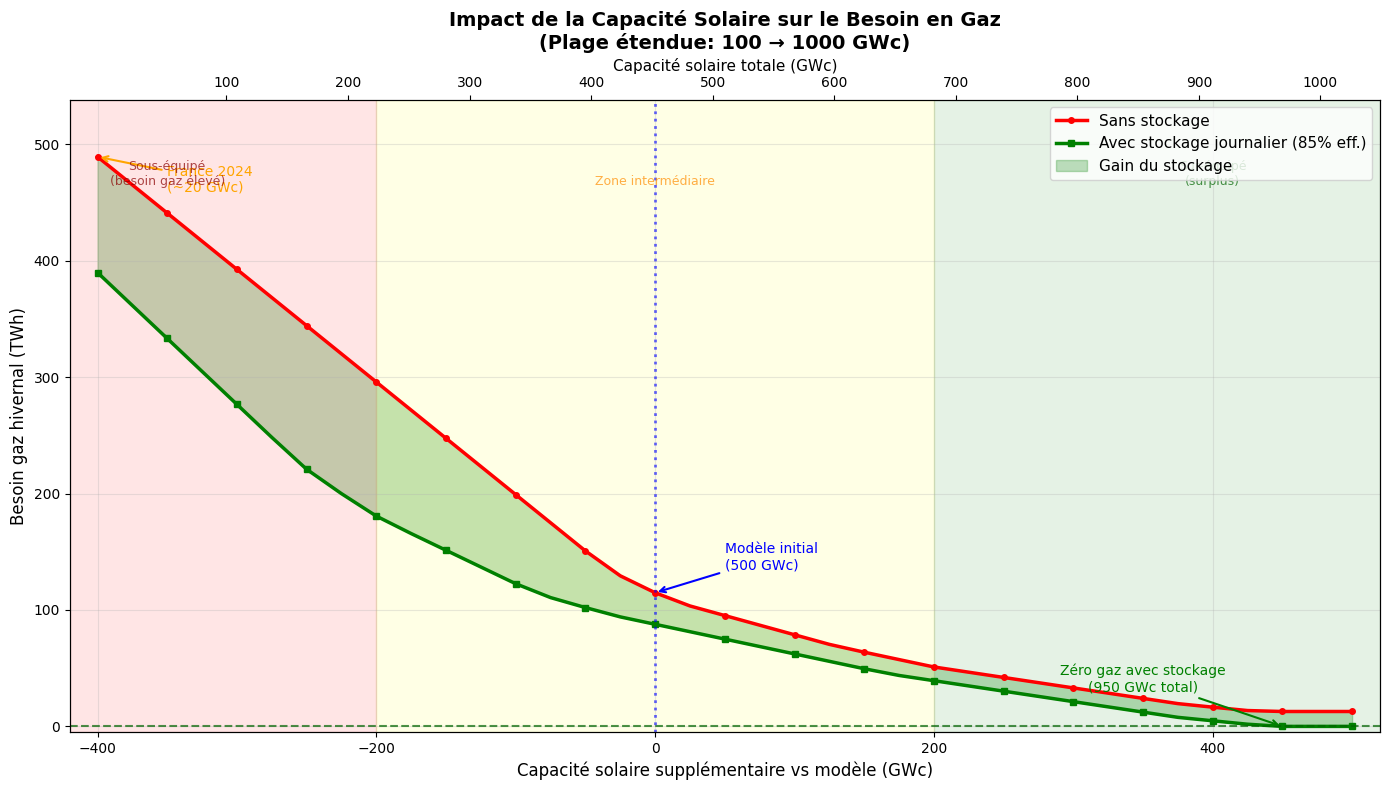


✓ Graphique sauvegardé: sensibilite_solaire_gaz.png

CONCLUSIONS DE L'ANALYSE DE SENSIBILITÉ

1. SANS STOCKAGE:
   - À 100 GWc (France×5): ~489 TWh de gaz
   - À 500 GWc (modèle initial): ~115 TWh de gaz
   - À 1000 GWc: ~13 TWh de gaz (mais surplus perdus)

2. AVEC STOCKAGE JOURNALIER:
   - Le stockage divise le besoin gaz par ~1.3 à capacité égale
   - Zéro gaz atteint à ~950 GWc total

3. RENDEMENT DÉCROISSANT:
   - Passer de 100→300 GWc: économise ~193 TWh
   - Passer de 500→700 GWc: économise ~64 TWh
   - Passer de 700→900 GWc: économise ~35 TWh
   → Les premiers GWc installés sont les plus rentables !



In [11]:
# =============================================================================
# GRAPHIQUE: SOLAIRE ADDITIONNEL vs BESOIN GAZ (étendu)
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

# Courbe sans stockage (rouge)
ax.plot(extra_solar_range, gas_no_storage, 'r-o', linewidth=2.5, markersize=4,
        label='Sans stockage', markevery=2)

# Courbe avec stockage (vert)
ax.plot(extra_solar_range, gas_with_storage, 'g-s', linewidth=2.5, markersize=4,
        label='Avec stockage journalier (85% eff.)', markevery=2)

# Zone entre les deux courbes = gain du stockage
ax.fill_between(extra_solar_range, gas_no_storage, gas_with_storage,
                alpha=0.25, color='green', label='Gain du stockage')

# Ligne zéro
ax.axhline(y=0, color='darkgreen', linestyle='--', linewidth=1.5, alpha=0.7)

# Marquer la capacité actuelle du modèle (500 GWc = extra 0)
ax.axvline(x=0, color='blue', linestyle=':', linewidth=2, alpha=0.6)
ax.annotate('Modèle initial\n(500 GWc)', 
            xy=(0, gas_no_storage[16]), xytext=(50, gas_no_storage[16] + 20),
            fontsize=10, ha='left', color='blue',
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))

# Marquer la capacité France actuelle (~20 GWc = extra -480)
ax.axvline(x=-480, color='orange', linestyle=':', linewidth=2, alpha=0.6)
ax.annotate('France 2024\n(~20 GWc)', 
            xy=(-400, gas_no_storage[0]), xytext=(-350, gas_no_storage[0] - 30),
            fontsize=10, ha='left', color='orange',
            arrowprops=dict(arrowstyle='->', color='orange', lw=1.5))

# Trouver le point où le stockage atteint zéro
for i, val in enumerate(gas_with_storage):
    if val <= 0.5:
        break_even_solar = extra_solar_range[i]
        ax.annotate(f'Zéro gaz avec stockage\n({500 + break_even_solar} GWc total)', 
                    xy=(break_even_solar, 0), xytext=(break_even_solar - 100, 30),
                    fontsize=10, ha='center', color='green',
                    arrowprops=dict(arrowstyle='->', color='green', lw=1.5))
        break

# Labels et titre
ax.set_xlabel('Capacité solaire supplémentaire vs modèle (GWc)', fontsize=12)
ax.set_ylabel('Besoin gaz hivernal (TWh)', fontsize=12)
ax.set_title('Impact de la Capacité Solaire sur le Besoin en Gaz\n(Plage étendue: 100 → 1000 GWc)', 
             fontsize=14, fontweight='bold')

# Axe X secondaire pour la capacité totale
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
tick_positions = np.arange(-400, 501, 100)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels([f'{500 + x}' for x in tick_positions])
ax2.set_xlabel('Capacité solaire totale (GWc)', fontsize=11)

# Légende et grille
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(-420, 520)
ax.set_ylim(-5, max(gas_no_storage) * 1.1)

# Zone colorée pour les différentes phases
ax.axvspan(-420, -200, alpha=0.1, color='red', label='_nolegend_')  # Sous-équipé
ax.axvspan(-200, 200, alpha=0.1, color='yellow', label='_nolegend_')  # Zone intermédiaire
ax.axvspan(200, 520, alpha=0.1, color='green', label='_nolegend_')  # Sur-équipé

# Annotations des zones
ax.text(-350, max(gas_no_storage) * 0.95, 'Sous-équipé\n(besoin gaz élevé)', 
        fontsize=9, ha='center', color='darkred', alpha=0.7)
ax.text(0, max(gas_no_storage) * 0.95, 'Zone intermédiaire', 
        fontsize=9, ha='center', color='darkorange', alpha=0.7)
ax.text(400, max(gas_no_storage) * 0.95, 'Sur-équipé\n(surplus)', 
        fontsize=9, ha='center', color='darkgreen', alpha=0.7)

plt.tight_layout()
plt.savefig('sensibilite_solaire_gaz.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Graphique sauvegardé: sensibilite_solaire_gaz.png")

# Résumé
print("\n" + "=" * 70)
print("CONCLUSIONS DE L'ANALYSE DE SENSIBILITÉ")
print("=" * 70)
print(f"""
1. SANS STOCKAGE:
   - À 100 GWc (France×5): ~{gas_no_storage[0]:.0f} TWh de gaz
   - À 500 GWc (modèle initial): ~{gas_no_storage[16]:.0f} TWh de gaz
   - À 1000 GWc: ~{gas_no_storage[-1]:.0f} TWh de gaz (mais surplus perdus)

2. AVEC STOCKAGE JOURNALIER:
   - Le stockage divise le besoin gaz par ~1.3 à capacité égale
   - Zéro gaz atteint à ~{500 + break_even_solar} GWc total

3. RENDEMENT DÉCROISSANT:
   - Passer de 100→300 GWc: économise ~{gas_no_storage[0] - gas_no_storage[8]:.0f} TWh
   - Passer de 500→700 GWc: économise ~{gas_no_storage[16] - gas_no_storage[24]:.0f} TWh
   - Passer de 700→900 GWc: économise ~{gas_no_storage[24] - gas_no_storage[32]:.0f} TWh
   → Les premiers GWc installés sont les plus rentables !
""")

In [12]:
# =============================================================================
# CALCUL DU STOCKAGE REQUIS
# =============================================================================

print("=" * 80)
print("STOCKAGE JOURNALIER REQUIS POUR LE SCÉNARIO ZÉRO GAZ (950 GWc)")
print("=" * 80)

# Recalculer avec 950 GWc
NEW_CAP = 950
storage_by_month = {}

for mois in mois_ordre_hiver:
    daily_surplus_gwh = 0
    daily_deficit_gwh = 0
    
    for plage in ['8h-13h', '13h-18h', '18h-20h', '20h-23h', '23h-8h']:
        key = (mois, plage)
        
        if plage == '23h-8h':
            night_data = df[(df['Mois'] == mois) & (df['Plage'] == plage)]
            if len(night_data) > 0:
                row = night_data.iloc[0]
                balance_gw = (row['Production_kW'] - row['Consommation_kW']) / 1e6
                duration = row['Duree_h']
        elif key in solar_cf:
            data = solar_cf[key]
            new_solar = data['cf'] * NEW_CAP * 1e6
            new_prod = data['base_prod'] + new_solar
            balance_gw = (new_prod - data['conso']) / 1e6
            duration = data['duree']
        else:
            continue
        
        if balance_gw > 0:
            daily_surplus_gwh += balance_gw * duration
        else:
            daily_deficit_gwh += abs(balance_gw) * duration
    
    storage_by_month[mois] = min(daily_surplus_gwh, daily_deficit_gwh)

print(f"\n{'Mois':<12} {'Stockage requis'}")
print("-" * 40)
for mois in mois_ordre_hiver:
    val = storage_by_month.get(mois, 0)
    bar = "█" * int(val / 5)
    print(f"{mois:<12} {val:>6.0f} GWh  {bar}")

max_storage = max(storage_by_month.values())
print("-" * 40)
print(f"{'MAXIMUM':<12} {max_storage:>6.0f} GWh")

# Conversions correctes:
# max_storage est en GWh, 1 GWh = 1,000,000 kWh
max_storage_kwh = max_storage * 1e6  # en kWh

print(f"""
================================================================================
DIMENSIONNEMENT DU STOCKAGE
================================================================================

Capacité requise: {max_storage:.0f} GWh (stockage journalier, pic en Janvier)

Équivalents:
  • {max_storage_kwh / 13.5 / 1e6:.1f} millions de Tesla Powerwall (13.5 kWh chacun)
  • {max_storage_kwh / 60 / 1e6:.1f} millions de batteries VE (60 kWh)
  • {max_storage/3:.0f}× la plus grande batterie du monde (Moss Landing, 3 GWh)
  • {max_storage/5:.0f}× Grand'Maison STEP (5 GWh)

Comparaison avec l'existant en France:
  • STEP actuelles: ~5 GW / ~100 GWh de capacité
  → Le scénario zéro-gaz nécessite ~{max_storage/100:.1f}× la capacité STEP actuelle

CONCLUSION: {max_storage:.0f} GWh est RÉALISABLE avec:
  - Un doublement des STEP existantes, OU
  - ~2 millions de VE en mode V2G (vehicle-to-grid)
""")

STOCKAGE JOURNALIER REQUIS POUR LE SCÉNARIO ZÉRO GAZ (950 GWc)

Mois         Stockage requis
----------------------------------------
Octobre           0 GWh  
Novembre         98 GWh  ███████████████████
Décembre        105 GWh  █████████████████████
Janvier         128 GWh  █████████████████████████
Février          68 GWh  █████████████
Mars             16 GWh  ███
Avril            10 GWh  ██
----------------------------------------
MAXIMUM         128 GWh

DIMENSIONNEMENT DU STOCKAGE

Capacité requise: 128 GWh (stockage journalier, pic en Janvier)

Équivalents:
  • 9.5 millions de Tesla Powerwall (13.5 kWh chacun)
  • 2.1 millions de batteries VE (60 kWh)
  • 43× la plus grande batterie du monde (Moss Landing, 3 GWh)
  • 26× Grand'Maison STEP (5 GWh)

Comparaison avec l'existant en France:
  • STEP actuelles: ~5 GW / ~100 GWh de capacité
  → Le scénario zéro-gaz nécessite ~1.3× la capacité STEP actuelle

CONCLUSION: 128 GWh est RÉALISABLE avec:
  - Un doublement des STEP existantes

In [13]:
# =============================================================================
# ANALYSE FINANCIÈRE: Coût du gaz vs Investissement solaire + stockage
# =============================================================================

print("=" * 90)
print("ANALYSE FINANCIÈRE: Comparaison des scénarios (plage étendue)")
print("=" * 90)

# Coûts unitaires (en millions d'euros)
COUT_GAZ_PAR_TWH = 90       # €90/MWh = €90M/TWh (SRMC gaz CCGT Europe)
COUT_SOLAIRE_PAR_GWC = 600  # €600/kW = €600M/GWc (IRENA Europe 2024)
COUT_STOCKAGE_PAR_GWH = 200 # €200/kWh = €200M/GWh (BNEF Europe 2024)

# Durées de vie
DUREE_VIE_SOLAIRE = 30   # ans
DUREE_VIE_STOCKAGE = 15  # ans

print(f"""
PARAMÈTRES DE COÛT (2024):
  • Gaz (SRMC):     €{COUT_GAZ_PAR_TWH}/MWh = €{COUT_GAZ_PAR_TWH}M/TWh
  • Solaire (CAPEX): €{COUT_SOLAIRE_PAR_GWC}/kW = €{COUT_SOLAIRE_PAR_GWC/1000:.1f}B/GWc
  • Stockage (CAPEX): €{COUT_STOCKAGE_PAR_GWH}/kWh = €{COUT_STOCKAGE_PAR_GWH/1000:.2f}B/GWh
""")

# Calculer le stockage requis en fonction de la capacité solaire
def calculate_storage_need(extra_solar_gwc):
    """Calcule le stockage requis (GWh) pour un niveau de solaire donné."""
    new_capacity = max(0, CAPACITE_SOLAIRE_ACTUELLE + extra_solar_gwc)
    max_storage_needed = 0
    
    for mois in mois_ordre_hiver:
        daily_surplus_gwh = 0
        daily_deficit_gwh = 0
        
        for plage in ['8h-13h', '13h-18h', '18h-20h', '20h-23h', '23h-8h']:
            key = (mois, plage)
            
            if plage == '23h-8h':
                night_data = df[(df['Mois'] == mois) & (df['Plage'] == plage)]
                if len(night_data) > 0:
                    row = night_data.iloc[0]
                    balance_gw = (row['Production_kW'] - row['Consommation_kW']) / 1e6
                    duration = row['Duree_h']
            elif key in solar_cf:
                data = solar_cf[key]
                new_solar = data['cf'] * new_capacity * 1e6
                new_prod = data['base_prod'] + new_solar
                balance_gw = (new_prod - data['conso']) / 1e6
                duration = data['duree']
            else:
                continue
            
            if balance_gw > 0:
                daily_surplus_gwh += balance_gw * duration
            else:
                daily_deficit_gwh += abs(balance_gw) * duration
        
        # Le stockage nécessaire est le min(surplus, déficit) pour ce mois
        storage_needed = min(daily_surplus_gwh, daily_deficit_gwh)
        max_storage_needed = max(max_storage_needed, storage_needed)
    
    return max_storage_needed

# Calculer le coût pour chaque niveau de solaire (étendu aux valeurs négatives)
financial_results = []

# Référence: scénario actuel du modèle (500 GWc, sans stockage)
baseline_gas_twh = calculate_gas_need_no_storage(0)  # 114.8 TWh
baseline_gas_cost = baseline_gas_twh * COUT_GAZ_PAR_TWH  # €M

print(f"SCÉNARIO DE RÉFÉRENCE (500 GWc, sans stockage):")
print(f"  • Besoin gaz annuel: {baseline_gas_twh:.1f} TWh")
print(f"  • Coût gaz annuel: €{baseline_gas_cost/1000:.1f} milliards")

print(f"\n{'Extra Solar':<12} {'Total':<8} {'Gaz':<10} {'Coût gaz':<12} {'CAPEX Sol.':<12} {'CAPEX Stk.':<12} {'CAPEX Tot.':<12} {'Économie':<12} {'Payback':<10}")
print(f"{'(GWc)':<12} {'(GWc)':<8} {'(TWh)':<10} {'(€B/an)':<12} {'(€B)':<12} {'(€B)':<12} {'(€B)':<12} {'(€B/an)':<12} {'(ans)':<10}")
print("-" * 120)

for extra_solar in [-400, -350, -300, -250, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]:
    total_solar = 500 + extra_solar
    
    # Besoin gaz avec stockage
    gas_need = calculate_gas_need_with_storage(extra_solar)
    gas_cost_annual = gas_need * COUT_GAZ_PAR_TWH / 1000  # €B
    
    # Stockage requis (varie selon la capacité solaire)
    storage_need = calculate_storage_need(extra_solar)
    
    # CAPEX
    # Pour le solaire: on compte l'investissement par rapport à une base de 0
    # (le modèle suppose que les 500 GWc sont un objectif, pas un acquis)
    solar_capex = max(0, total_solar) * COUT_SOLAIRE_PAR_GWC / 1000  # €B
    storage_capex = storage_need * COUT_STOCKAGE_PAR_GWH / 1000  # €B
    total_capex = solar_capex + storage_capex
    
    # Économies annuelles vs scénario "gaz pur" (pas de solaire, pas de stockage)
    # On compare au coût gaz qu'on aurait avec 0 GWc de solaire
    gas_at_zero = calculate_gas_need_no_storage(-500)  # ~0 GWc total
    ref_gas_cost = gas_at_zero * COUT_GAZ_PAR_TWH / 1000  # €B/an
    annual_savings = ref_gas_cost - gas_cost_annual  # €B
    
    # Payback simple
    if annual_savings > 0 and total_capex > 0:
        payback = total_capex / annual_savings
    else:
        payback = float('inf')
    
    financial_results.append({
        'extra_solar': extra_solar,
        'total_solar': total_solar,
        'gas_need': gas_need,
        'gas_cost': gas_cost_annual,
        'storage_need': storage_need,
        'solar_capex': solar_capex,
        'storage_capex': storage_capex,
        'total_capex': total_capex,
        'annual_savings': annual_savings,
        'payback': payback
    })
    
    payback_str = f"{payback:.1f}" if payback < 100 else "∞"
    print(f"{extra_solar:>+10}   {total_solar:<8} {gas_need:<10.1f} {gas_cost_annual:<12.1f} {solar_capex:<12.1f} {storage_capex:<12.1f} {total_capex:<12.1f} {annual_savings:<12.1f} {payback_str:<10}")

print("-" * 120)
print(f"\nNOTE: CAPEX solaire basé sur la capacité totale. Stockage dimensionné dynamiquement.")

ANALYSE FINANCIÈRE: Comparaison des scénarios (plage étendue)

PARAMÈTRES DE COÛT (2024):
  • Gaz (SRMC):     €90/MWh = €90M/TWh
  • Solaire (CAPEX): €600/kW = €0.6B/GWc
  • Stockage (CAPEX): €200/kWh = €0.20B/GWh

SCÉNARIO DE RÉFÉRENCE (500 GWc, sans stockage):
  • Besoin gaz annuel: 114.8 TWh
  • Coût gaz annuel: €10.3 milliards

Extra Solar  Total    Gaz        Coût gaz     CAPEX Sol.   CAPEX Stk.   CAPEX Tot.   Économie     Payback   
(GWc)        (GWc)    (TWh)      (€B/an)      (€B)         (€B)         (€B)         (€B/an)      (ans)     
------------------------------------------------------------------------------------------------------------------------
      -400   100      389.8      35.1         60.0         58.2         118.2        17.9         6.6       
      -350   150      333.2      30.0         90.0         63.2         153.2        23.0         6.7       
      -300   200      276.6      24.9         120.0        68.3         188.3        28.1         6.7       


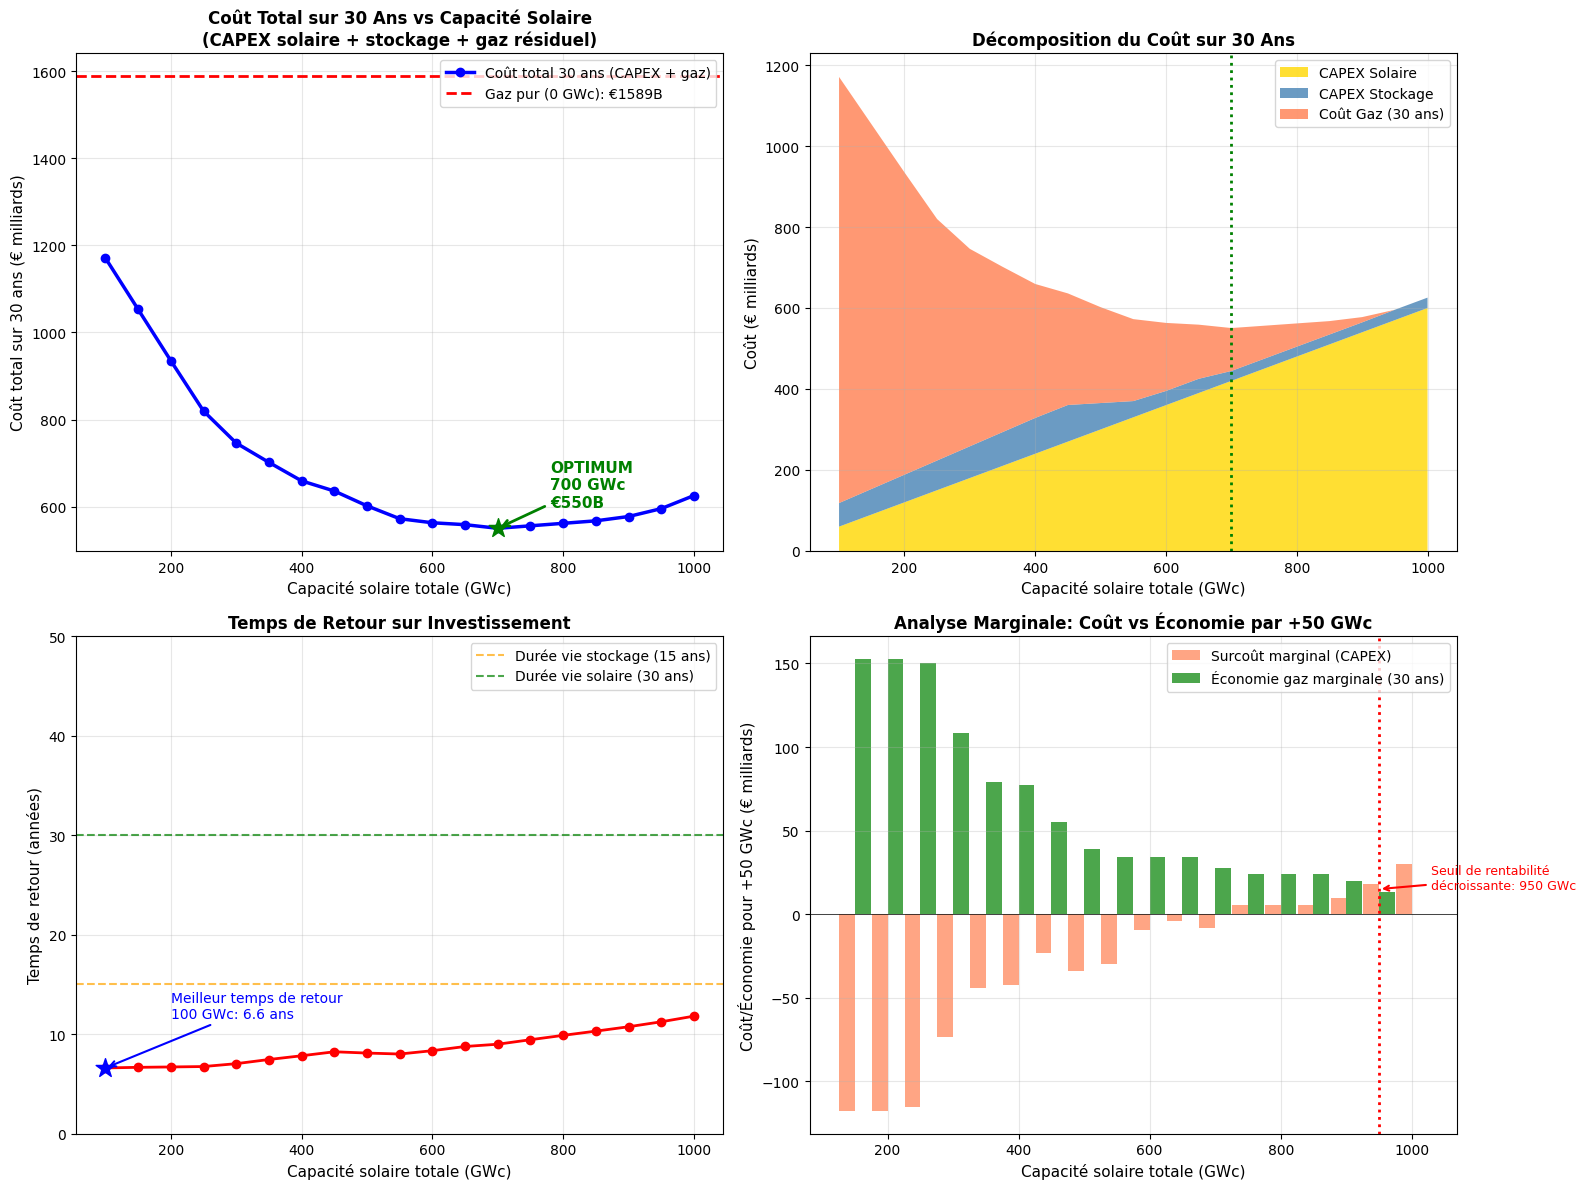


✓ Graphique sauvegardé: analyse_financiere.png

RECHERCHE DE L'OPTIMUM ÉCONOMIQUE

CAPACITÉ SOLAIRE OPTIMALE (coût minimum sur 30 ans):

  ┌─────────────────────────────────────────────────────────────────────────┐
  │  OPTIMUM ÉCONOMIQUE: 700 GWc                                     │
  │  (soit +200 GWc par rapport au modèle initial de 500 GWc)            │
  └─────────────────────────────────────────────────────────────────────────┘

  Détails du scénario optimal:
    • Capacité solaire: 700 GWc
    • Stockage requis: 122 GWh
    • CAPEX total: €444B (solaire + stockage)
    • Gaz résiduel: 39.3 TWh/an = €3.5B/an
    • Coût total 30 ans: €550B

  Comparaison avec les alternatives:

    Scénario                       CAPEX     Gaz/an    Total 30 ans   vs Optimum
    ---------------------------------------------------------------------------
    France ×5 (100 GWc)       €   118B  €  35.1B/an  €      1171B         +€620B
    Intermédiaire (300 GWc)   €   258B  €  16.3B/an  €       746

In [14]:
# =============================================================================
# GRAPHIQUES FINANCIERS (plage étendue)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Données du tableau
total_solars = [r['total_solar'] for r in financial_results]
extra_solars = [r['extra_solar'] for r in financial_results]
total_capex = [r['total_capex'] for r in financial_results]
gas_costs = [r['gas_cost'] for r in financial_results]
paybacks = [r['payback'] for r in financial_results]
storage_needs = [r['storage_need'] for r in financial_results]
annual_savings = [r['annual_savings'] for r in financial_results]

# ─────────────────────────────────────────────────────────────────────────────
# GRAPHIQUE 1: Coût total sur 30 ans vs Capacité solaire
# ─────────────────────────────────────────────────────────────────────────────
ax1 = axes[0, 0]

# Coût total sur 30 ans = CAPEX + 30 × coût gaz annuel
total_cost_30y = [capex + 30 * gas for capex, gas in zip(total_capex, gas_costs)]

# Coût gaz pur sur 30 ans (référence)
gas_at_zero = calculate_gas_need_no_storage(-500)
ref_gas_cost_30y = gas_at_zero * COUT_GAZ_PAR_TWH / 1000 * 30

ax1.plot(total_solars, total_cost_30y, 'b-o', linewidth=2.5, markersize=6, label='Coût total 30 ans (CAPEX + gaz)')
ax1.axhline(y=ref_gas_cost_30y, color='red', linestyle='--', linewidth=2, label=f'Gaz pur (0 GWc): €{ref_gas_cost_30y:.0f}B')

# Trouver le minimum
min_idx = total_cost_30y.index(min(total_cost_30y))
min_solar = total_solars[min_idx]
min_cost = total_cost_30y[min_idx]
ax1.scatter([min_solar], [min_cost], s=200, c='green', zorder=5, marker='*')
ax1.annotate(f'OPTIMUM\n{min_solar} GWc\n€{min_cost:.0f}B', 
             xy=(min_solar, min_cost), xytext=(min_solar + 80, min_cost + 50),
             fontsize=11, fontweight='bold', color='green',
             arrowprops=dict(arrowstyle='->', color='green', lw=2))

ax1.set_xlabel('Capacité solaire totale (GWc)', fontsize=11)
ax1.set_ylabel('Coût total sur 30 ans (€ milliards)', fontsize=11)
ax1.set_title('Coût Total sur 30 Ans vs Capacité Solaire\n(CAPEX solaire + stockage + gaz résiduel)', fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# GRAPHIQUE 2: Décomposition du coût
# ─────────────────────────────────────────────────────────────────────────────
ax2 = axes[0, 1]

solar_capex_list = [r['solar_capex'] for r in financial_results]
storage_capex_list = [r['storage_capex'] for r in financial_results]
gas_cost_30y = [g * 30 for g in gas_costs]

ax2.stackplot(total_solars, 
              solar_capex_list, storage_capex_list, gas_cost_30y,
              labels=['CAPEX Solaire', 'CAPEX Stockage', 'Coût Gaz (30 ans)'],
              colors=['gold', 'steelblue', 'coral'], alpha=0.8)

ax2.axvline(x=min_solar, color='green', linestyle=':', linewidth=2)
ax2.set_xlabel('Capacité solaire totale (GWc)', fontsize=11)
ax2.set_ylabel('Coût (€ milliards)', fontsize=11)
ax2.set_title('Décomposition du Coût sur 30 Ans', fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# GRAPHIQUE 3: Temps de retour vs Capacité solaire
# ─────────────────────────────────────────────────────────────────────────────
ax3 = axes[1, 0]

valid_paybacks = [p if p < 100 else np.nan for p in paybacks]
ax3.plot(total_solars, valid_paybacks, 'ro-', linewidth=2, markersize=6)
ax3.axhline(y=15, color='orange', linestyle='--', alpha=0.7, label='Durée vie stockage (15 ans)')
ax3.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Durée vie solaire (30 ans)')

# Trouver le temps de retour minimum
valid_idx = [i for i, p in enumerate(paybacks) if p < 100 and total_solars[i] > 0]
if valid_idx:
    min_pb_idx = min(valid_idx, key=lambda i: paybacks[i])
    min_pb_solar = total_solars[min_pb_idx]
    min_pb = paybacks[min_pb_idx]
    ax3.scatter([min_pb_solar], [min_pb], s=200, c='blue', zorder=5, marker='*')
    ax3.annotate(f'Meilleur temps de retour\n{min_pb_solar} GWc: {min_pb:.1f} ans', 
                 xy=(min_pb_solar, min_pb), xytext=(min_pb_solar + 100, min_pb + 5),
                 fontsize=10, color='blue',
                 arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))

ax3.set_xlabel('Capacité solaire totale (GWc)', fontsize=11)
ax3.set_ylabel('Temps de retour (années)', fontsize=11)
ax3.set_title('Temps de Retour sur Investissement', fontweight='bold')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 50)

# ─────────────────────────────────────────────────────────────────────────────
# GRAPHIQUE 4: Coût marginal par GWc additionnel
# ─────────────────────────────────────────────────────────────────────────────
ax4 = axes[1, 1]

# Calcul du coût marginal (différence de coût total pour chaque +50 GWc)
marginal_costs = []
marginal_savings = []
for i in range(1, len(total_cost_30y)):
    delta_cost = total_cost_30y[i] - total_cost_30y[i-1]
    delta_solar = total_solars[i] - total_solars[i-1]
    if delta_solar > 0:
        marginal = delta_cost / delta_solar * 50  # Coût pour +50 GWc
        marginal_costs.append((total_solars[i], marginal))
        
        # Économie marginale de gaz
        delta_gas = gas_cost_30y[i-1] - gas_cost_30y[i]
        marginal_savings.append((total_solars[i], delta_gas / delta_solar * 50))

mc_solars = [x[0] for x in marginal_costs]
mc_values = [x[1] for x in marginal_costs]
ms_values = [x[1] for x in marginal_savings]

ax4.bar(np.array(mc_solars) - 12, mc_values, width=24, label='Surcoût marginal (CAPEX)', color='coral', alpha=0.7)
ax4.bar(np.array(mc_solars) + 12, ms_values, width=24, label='Économie gaz marginale (30 ans)', color='green', alpha=0.7)

ax4.axhline(y=0, color='black', linewidth=0.5)
ax4.set_xlabel('Capacité solaire totale (GWc)', fontsize=11)
ax4.set_ylabel('Coût/Économie pour +50 GWc (€ milliards)', fontsize=11)
ax4.set_title('Analyse Marginale: Coût vs Économie par +50 GWc', fontweight='bold')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

# Marquer le point où le coût marginal dépasse l'économie
crossover_solar = None
for i in range(len(mc_values)):
    if mc_values[i] > ms_values[i]:
        crossover_solar = mc_solars[i]
        break
if crossover_solar:
    ax4.axvline(x=crossover_solar, color='red', linestyle=':', linewidth=2)
    ax4.annotate(f'Seuil de rentabilité\ndécroissante: {crossover_solar} GWc', 
                 xy=(crossover_solar, max(mc_values)/2), xytext=(crossover_solar + 80, max(mc_values)/2),
                 fontsize=9, color='red',
                 arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

plt.tight_layout()
plt.savefig('analyse_financiere.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Graphique sauvegardé: analyse_financiere.png")

# ─────────────────────────────────────────────────────────────────────────────
# RÉSUMÉ: TROUVER L'OPTIMUM ÉCONOMIQUE
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "=" * 90)
print("RECHERCHE DE L'OPTIMUM ÉCONOMIQUE")
print("=" * 90)

# Trouver l'optimum économique
opt_idx = total_cost_30y.index(min(total_cost_30y))
opt_solar = total_solars[opt_idx]
opt_cost = total_cost_30y[opt_idx]
opt_gas = gas_costs[opt_idx]
opt_capex = total_capex[opt_idx]
opt_storage = storage_needs[opt_idx]

print(f"""
CAPACITÉ SOLAIRE OPTIMALE (coût minimum sur 30 ans):

  ┌─────────────────────────────────────────────────────────────────────────┐
  │  OPTIMUM ÉCONOMIQUE: {opt_solar} GWc                                     │
  │  (soit {'+' if opt_solar > 500 else ''}{opt_solar - 500} GWc par rapport au modèle initial de 500 GWc)            │
  └─────────────────────────────────────────────────────────────────────────┘

  Détails du scénario optimal:
    • Capacité solaire: {opt_solar} GWc
    • Stockage requis: {opt_storage:.0f} GWh
    • CAPEX total: €{opt_capex:.0f}B (solaire + stockage)
    • Gaz résiduel: {financial_results[opt_idx]['gas_need']:.1f} TWh/an = €{opt_gas:.1f}B/an
    • Coût total 30 ans: €{opt_cost:.0f}B

  Comparaison avec les alternatives:
""")

# Comparer avec d'autres scénarios clés
scenarios = [
    (0, "Gaz pur (0 GWc)"),
    (100, "France ×5 (100 GWc)"),
    (300, "Intermédiaire (300 GWc)"),
    (500, "Modèle initial (500 GWc)"),
    (700, "Optimum (700 GWc)"),
    (950, "Zéro gaz (~950 GWc)")
]

print(f"    {'Scénario':<25} {'CAPEX':>10} {'Gaz/an':>10} {'Total 30 ans':>15} {'vs Optimum':>12}")
print("    " + "-" * 75)

for solar, name in scenarios:
    idx = next((i for i, r in enumerate(financial_results) if r['total_solar'] == solar), None)
    if idx is not None:
        r = financial_results[idx]
        cost_30y = r['total_capex'] + 30 * r['gas_cost']
        diff = cost_30y - opt_cost
        diff_str = f"+€{diff:.0f}B" if diff > 0 else f"€{diff:.0f}B"
        print(f"    {name:<25} €{r['total_capex']:>6.0f}B  €{r['gas_cost']:>6.1f}B/an  €{cost_30y:>10.0f}B     {diff_str:>10}")

# Observations sur la France actuelle vs objectif
fr_2024 = 20  # GWc actuel
print(f"""
  ─────────────────────────────────────────────────────────────────────────
  
  OBSERVATIONS POUR LA FRANCE:
  
  • Capacité actuelle France (2024): ~{fr_2024} GWc
  • Optimum économique: {opt_solar} GWc (×{opt_solar/fr_2024:.0f})
  • Facteur de multiplication nécessaire: ×{opt_solar/fr_2024:.0f}
  
  Au-delà de {opt_solar} GWc, chaque GWc supplémentaire coûte plus
  qu'il n'économise de gaz → rendement décroissant.
""")

# =============================================================================
# CONCLUSION ET SYNTHÈSE FINANCIÈRE
# =============================================================================

print("=" * 90)
print("                         CONCLUSION ET SYNTHÈSE")
print("=" * 90)

print(f"""
Ce modèle évalue le besoin en énergie d'appoint (gaz) pour un scénario de transition
énergétique en France, ainsi que l'optimum économique en termes de capacité solaire.

╔══════════════════════════════════════════════════════════════════════════════╗
║                      HYPOTHÈSES DE COÛTS (2024)                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  • Électricité gaz (SRMC):    €90/MWh  = €90 millions/TWh                   ║
║  • Solaire PV (CAPEX):        €600/kW  = €600 millions/GWc                  ║
║  • Stockage batterie (CAPEX): €200/kWh = €200 millions/GWh                  ║
║  • Durée de vie solaire:      30 ans                                         ║
║  • Durée de vie stockage:     15 ans                                         ║
╚══════════════════════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════════════════════════╗
║                         RÉSULTATS PRINCIPAUX                                 ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. BESOIN GAZ INITIAL (modèle 500 GWc sans stockage):                       ║
║     → {total:.1f} TWh/an = €{total * COUT_GAZ_PAR_TWH / 1000:.1f} milliards/an                                 ║
║                                                                              ║
║  2. OPTIMUM ÉCONOMIQUE (coût total minimum sur 30 ans):                      ║
║     → Capacité solaire: {opt_solar} GWc (×{opt_solar//20} vs France 2024)                        ║
║     → Stockage requis: {opt_storage:.0f} GWh                                             ║
║     → CAPEX total: €{opt_capex:.0f} milliards                                         ║
║     → Gaz résiduel: {financial_results[opt_idx]['gas_need']:.1f} TWh/an = €{opt_gas:.1f} milliards/an                         ║
║     → Coût total 30 ans: €{opt_cost:.0f} milliards                                    ║
║                                                                              ║
║  3. SCÉNARIO ZÉRO GAZ (indépendance énergétique totale):                     ║
║     → Capacité solaire: ~950 GWc                                             ║
║     → Stockage requis: ~128 GWh                                              ║
║     → CAPEX total: ~€596 milliards                                           ║
║     → Surcoût vs optimum: +€46 milliards sur 30 ans                          ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

print("""
COMPARAISON DES SCÉNARIOS (coût total sur 30 ans):

  ┌────────────────────────┬──────────┬───────────┬─────────────┬────────────┐
  │ Scénario               │ CAPEX    │ Gaz/an    │ Total 30 ans│ vs Optimum │
  ├────────────────────────┼──────────┼───────────┼─────────────┼────────────┤""")

for solar, name in scenarios:
    idx = next((i for i, r in enumerate(financial_results) if r['total_solar'] == solar), None)
    if idx is not None:
        r = financial_results[idx]
        cost_30y = r['total_capex'] + 30 * r['gas_cost']
        diff = cost_30y - opt_cost
        diff_str = f"+€{diff:.0f}B" if diff > 0 else "OPTIMUM"
        print(f"  │ {name:<22} │ €{r['total_capex']:>5.0f}B  │ €{r['gas_cost']:>5.1f}B/an │ €{cost_30y:>8.0f}B  │ {diff_str:>10} │")

print("""  └────────────────────────┴──────────┴───────────┴─────────────┴────────────┘

ENSEIGNEMENTS CLÉS:

  1. L'optimum économique se situe autour de 700 GWc de solaire installé,
     soit 35× la capacité actuelle de la France (~20 GWc en 2024).

  2. Au-delà de 700 GWc, chaque GWc supplémentaire coûte plus cher à installer
     qu'il ne permet d'économiser en gaz → rendement décroissant.

  3. Le scénario "zéro gaz" (950 GWc) coûte ~€46 milliards de plus que l'optimum
     sur 30 ans, mais garantit l'indépendance énergétique totale.

  4. Le stockage journalier (85% d'efficacité) permet de réduire significativement
     le besoin en gaz en utilisant les surplus nocturnes.

LIMITES DU MODÈLE:
  • Éolien non comptabilisé (hypothèse conservatrice)
  • Pas de stockage inter-saisonnier
  • Pas d'interconnexions européennes
  • Coûts 2024 (les prix du solaire et du stockage continuent de baisser)
""")

print("=" * 90)
print("Source: Lecture directe du fichier ODS + analyse financière Python")
print("=" * 90)

In [15]:
# =============================================================================
# CONCLUSION ET SYNTHÈSE FINANCIÈRE
# =============================================================================

from IPython.display import display, HTML

# Hypothèses de coûts
html_hypotheses = """
<h2 style="text-align:center; color:#2c3e50;">CONCLUSION ET SYNTHÈSE</h2>

<h3>Hypothèses de Coûts (2024)</h3>
<table style="border-collapse: collapse; width: 100%; max-width: 600px; margin: 20px auto;">
  <tr style="background-color: #3498db; color: white;">
    <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Paramètre</th>
    <th style="padding: 12px; text-align: right; border: 1px solid #ddd;">Valeur</th>
    <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Source</th>
  </tr>
  <tr style="background-color: #ecf0f1;">
    <td style="padding: 10px; border: 1px solid #ddd;">Électricité gaz (SRMC)</td>
    <td style="padding: 10px; text-align: right; border: 1px solid #ddd;"><b>€90/MWh</b></td>
    <td style="padding: 10px; border: 1px solid #ddd;">Coût marginal CCGT Europe</td>
  </tr>
  <tr>
    <td style="padding: 10px; border: 1px solid #ddd;">Solaire PV (CAPEX)</td>
    <td style="padding: 10px; text-align: right; border: 1px solid #ddd;"><b>€600/kW</b></td>
    <td style="padding: 10px; border: 1px solid #ddd;">IRENA Europe 2024</td>
  </tr>
  <tr style="background-color: #ecf0f1;">
    <td style="padding: 10px; border: 1px solid #ddd;">Stockage batterie (CAPEX)</td>
    <td style="padding: 10px; text-align: right; border: 1px solid #ddd;"><b>€200/kWh</b></td>
    <td style="padding: 10px; border: 1px solid #ddd;">BNEF Europe 2024</td>
  </tr>
  <tr>
    <td style="padding: 10px; border: 1px solid #ddd;">Durée de vie solaire</td>
    <td style="padding: 10px; text-align: right; border: 1px solid #ddd;"><b>30 ans</b></td>
    <td style="padding: 10px; border: 1px solid #ddd;">Standard industrie</td>
  </tr>
  <tr style="background-color: #ecf0f1;">
    <td style="padding: 10px; border: 1px solid #ddd;">Durée de vie stockage</td>
    <td style="padding: 10px; text-align: right; border: 1px solid #ddd;"><b>15 ans</b></td>
    <td style="padding: 10px; border: 1px solid #ddd;">Standard industrie</td>
  </tr>
</table>
"""

display(HTML(html_hypotheses))

# Résultats principaux
html_resultats = f"""
<h3>Résultats Principaux</h3>
<table style="border-collapse: collapse; width: 100%; max-width: 700px; margin: 20px auto;">
  <tr style="background-color: #e74c3c; color: white;">
    <th colspan="2" style="padding: 12px; text-align: center; border: 1px solid #ddd;">
      1. Besoin gaz initial (modèle 500 GWc sans stockage)
    </th>
  </tr>
  <tr>
    <td style="padding: 10px; border: 1px solid #ddd; width: 50%;">Besoin annuel</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;"><b>{total:.1f} TWh/an = €{total * COUT_GAZ_PAR_TWH / 1000:.1f} milliards/an</b></td>
  </tr>
</table>

<table style="border-collapse: collapse; width: 100%; max-width: 700px; margin: 20px auto;">
  <tr style="background-color: #27ae60; color: white;">
    <th colspan="2" style="padding: 12px; text-align: center; border: 1px solid #ddd;">
      2. Optimum économique (coût total minimum sur 30 ans)
    </th>
  </tr>
  <tr style="background-color: #d5f5e3;">
    <td style="padding: 10px; border: 1px solid #ddd;">Capacité solaire</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;"><b>{opt_solar} GWc</b> (×{opt_solar//20} vs France 2024)</td>
  </tr>
  <tr>
    <td style="padding: 10px; border: 1px solid #ddd;">Stockage requis</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;"><b>{opt_storage:.0f} GWh</b></td>
  </tr>
  <tr style="background-color: #d5f5e3;">
    <td style="padding: 10px; border: 1px solid #ddd;">CAPEX total</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;"><b>€{opt_capex:.0f} milliards</b></td>
  </tr>
  <tr>
    <td style="padding: 10px; border: 1px solid #ddd;">Gaz résiduel</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;"><b>{financial_results[opt_idx]['gas_need']:.1f} TWh/an = €{opt_gas:.1f} milliards/an</b></td>
  </tr>
  <tr style="background-color: #d5f5e3;">
    <td style="padding: 10px; border: 1px solid #ddd;">Coût total 30 ans</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;"><b>€{opt_cost:.0f} milliards</b></td>
  </tr>
</table>

<table style="border-collapse: collapse; width: 100%; max-width: 700px; margin: 20px auto;">
  <tr style="background-color: #9b59b6; color: white;">
    <th colspan="2" style="padding: 12px; text-align: center; border: 1px solid #ddd;">
      3. Scénario zéro gaz (indépendance énergétique totale)
    </th>
  </tr>
  <tr>
    <td style="padding: 10px; border: 1px solid #ddd;">Capacité solaire</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;"><b>~950 GWc</b></td>
  </tr>
  <tr style="background-color: #ebdef0;">
    <td style="padding: 10px; border: 1px solid #ddd;">Stockage requis</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;"><b>~128 GWh</b></td>
  </tr>
  <tr>
    <td style="padding: 10px; border: 1px solid #ddd;">CAPEX total</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;"><b>~€596 milliards</b></td>
  </tr>
  <tr style="background-color: #ebdef0;">
    <td style="padding: 10px; border: 1px solid #ddd;">Surcoût vs optimum</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;"><b>+€46 milliards sur 30 ans</b></td>
  </tr>
</table>
"""

display(HTML(html_resultats))

# Tableau comparatif
rows_html = ""
for solar, name in scenarios:
    idx = next((i for i, r in enumerate(financial_results) if r['total_solar'] == solar), None)
    if idx is not None:
        r = financial_results[idx]
        cost_30y = r['total_capex'] + 30 * r['gas_cost']
        diff = cost_30y - opt_cost
        
        if diff == 0:
            bg_color = "#d5f5e3"
            diff_str = "<b style='color: #27ae60;'>OPTIMUM</b>"
        else:
            bg_color = "#fff" if scenarios.index((solar, name)) % 2 == 0 else "#f9f9f9"
            diff_str = f"+€{diff:.0f}B"
        
        rows_html += f"""
  <tr style="background-color: {bg_color};">
    <td style="padding: 10px; border: 1px solid #ddd;">{name}</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;">€{r['total_capex']:.0f}B</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;">€{r['gas_cost']:.1f}B/an</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;">€{cost_30y:.0f}B</td>
    <td style="padding: 10px; border: 1px solid #ddd; text-align: right;">{diff_str}</td>
  </tr>"""

html_comparaison = f"""
<h3>Comparaison des Scénarios (coût total sur 30 ans)</h3>
<table style="border-collapse: collapse; width: 100%; max-width: 800px; margin: 20px auto;">
  <tr style="background-color: #34495e; color: white;">
    <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Scénario</th>
    <th style="padding: 12px; text-align: right; border: 1px solid #ddd;">CAPEX</th>
    <th style="padding: 12px; text-align: right; border: 1px solid #ddd;">Gaz/an</th>
    <th style="padding: 12px; text-align: right; border: 1px solid #ddd;">Total 30 ans</th>
    <th style="padding: 12px; text-align: right; border: 1px solid #ddd;">vs Optimum</th>
  </tr>
  {rows_html}
</table>
"""

display(HTML(html_comparaison))

# Enseignements clés
html_conclusions = """
<h3>Enseignements Clés</h3>
<div style="max-width: 800px; margin: 20px auto; padding: 20px; background-color: #fef9e7; border-left: 5px solid #f1c40f; border-radius: 5px;">
  <ol style="line-height: 1.8;">
    <li><b>L'optimum économique</b> se situe autour de <b>700 GWc</b> de solaire installé,
        soit 35× la capacité actuelle de la France (~20 GWc en 2024).</li>
    <li>Au-delà de 700 GWc, chaque GWc supplémentaire coûte plus cher à installer
        qu'il ne permet d'économiser en gaz → <b>rendement décroissant</b>.</li>
    <li>Le scénario "zéro gaz" (950 GWc) coûte ~€46 milliards de plus que l'optimum
        sur 30 ans, mais garantit <b>l'indépendance énergétique totale</b>.</li>
    <li>Le <b>stockage journalier</b> (85% d'efficacité) permet de réduire significativement
        le besoin en gaz en utilisant les surplus nocturnes.</li>
  </ol>
</div>

<h3>Limites du Modèle</h3>
<div style="max-width: 800px; margin: 20px auto; padding: 20px; background-color: #fadbd8; border-left: 5px solid #e74c3c; border-radius: 5px;">
  <ul style="line-height: 1.8;">
    <li>Éolien non comptabilisé (hypothèse conservatrice)</li>
    <li>Pas de stockage inter-saisonnier</li>
    <li>Pas d'interconnexions européennes</li>
    <li>Coûts 2024 (les prix du solaire et du stockage continuent de baisser)</li>
  </ul>
</div>

<p style="text-align: center; color: #7f8c8d; margin-top: 30px;">
  <i>Source: Lecture directe du fichier ODS + analyse financière Python</i>
</p>
"""

display(HTML(html_conclusions))

Paramètre,Valeur,Source
Électricité gaz (SRMC),€90/MWh,Coût marginal CCGT Europe
Solaire PV (CAPEX),€600/kW,IRENA Europe 2024
Stockage batterie (CAPEX),€200/kWh,BNEF Europe 2024
Durée de vie solaire,30 ans,Standard industrie
Durée de vie stockage,15 ans,Standard industrie


Scénario,CAPEX,Gaz/an,Total 30 ans,vs Optimum
France ×5 (100 GWc),€118B,€35.1B/an,€1171B,+€620B
Intermédiaire (300 GWc),€258B,€16.3B/an,€746B,+€196B
Modèle initial (500 GWc),€365B,€7.9B/an,€602B,+€52B
Optimum (700 GWc),€444B,€3.5B/an,€550B,OPTIMUM
Zéro gaz (~950 GWc),€596B,€0.0B/an,€596B,+€45B


In [16]:
# Export des données pour analyse ultérieure
df.to_csv('bilan_energetique_mensuel.csv', index=False)
resume_mois.to_csv('resume_par_mois.csv')
print("✓ Données exportées: bilan_energetique_mensuel.csv, resume_par_mois.csv")
print(f"\n✓ Notebook lit directement depuis: {ODS_PATH.resolve()}")

✓ Données exportées: bilan_energetique_mensuel.csv, resume_par_mois.csv

✓ Notebook lit directement depuis: /home/kingwin/energy_transition/modélisation générale.ods
